# RDCT (really bad) Demo:

This is a demo of what the RDCT outputs would look like if you compressed then uncompressed them like the image below:


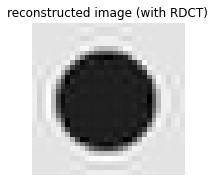


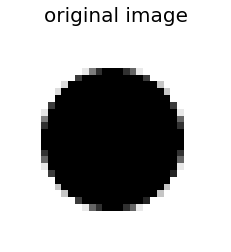


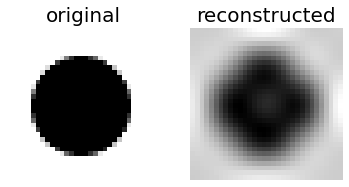

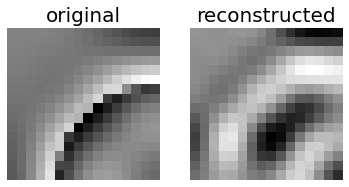

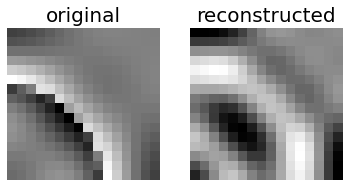

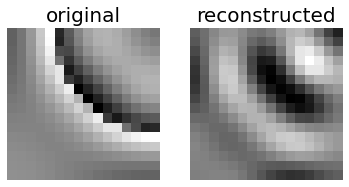

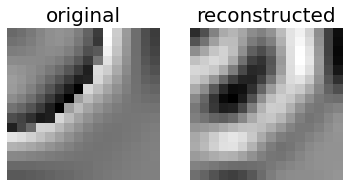

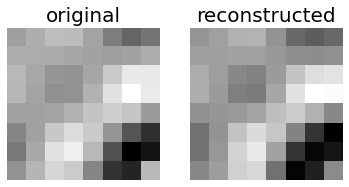

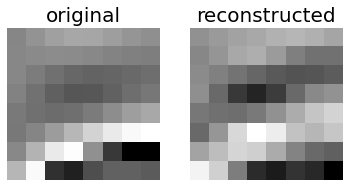

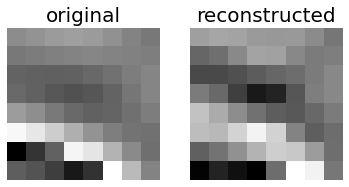

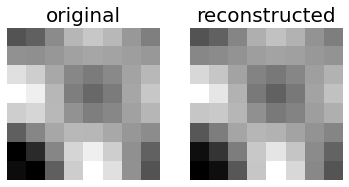

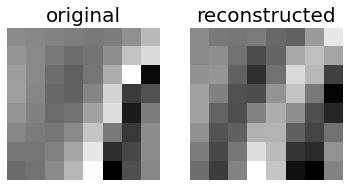

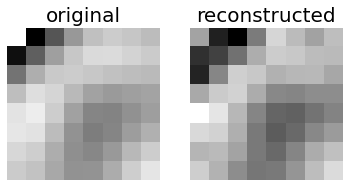

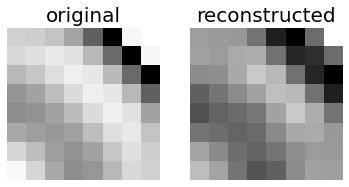

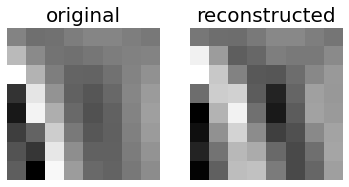

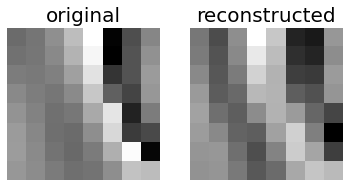

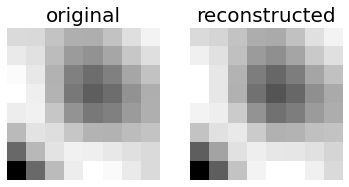

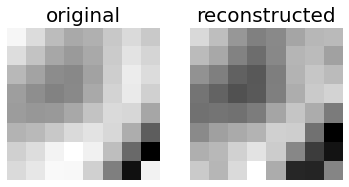

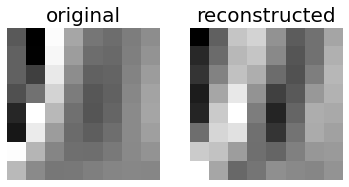

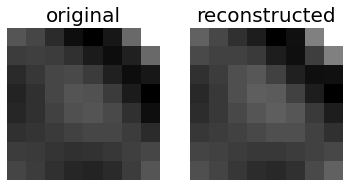

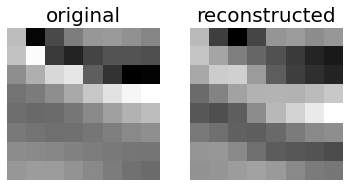

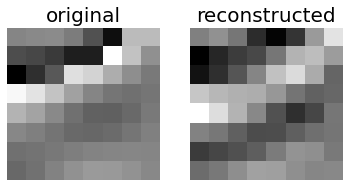

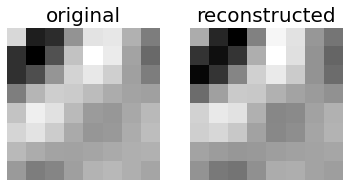

Saved as RDCT.png


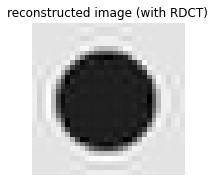

Total transforms: 84
Current image lossyness (The lower, the better!):  0
Estimated file size (total guess, take this with a KILOGRAM of salt): 1260 Bytes


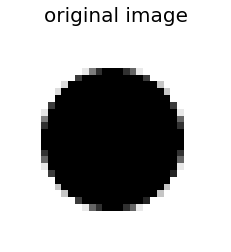

In [11]:
#@title Default title text
path_to_image = "test3.png" #@param {type:"string"}
debug_render = True #@param {type:"boolean"}
DCT_DIVISIONS_PER_SUB_IMG = 4 #@param {type:"integer"}
recursion_levels = 3 #@param {type:"integer"}
file_path = path_to_image

# Still not quite sure if this works
# TODO: implement img_target_loss
# TODO: implement a working loss
# TODO: make code quality alot better and semi-readable

from scipy.fftpack import dct, idct

from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
import math

# ADD this eventually
img_target_loss = 500

subdivisions = recursion_levels
DCT_DIVISIONS = DCT_DIVISIONS_PER_SUB_IMG

# read img
im = rgb2gray(imread(file_path))
im *= 256
original_image = im.copy()
mod_img = im


img_width = im.shape[1]
img_height = im.shape[0]

reconstructed_img = np.zeros((img_height, img_width))
total_transforms = 0
img_loss = 0

def save_img(img_input):
  save_im = Image.fromarray(img_input)
  plt.gray()
  plt.subplot(121), plt.imshow(save_im), plt.axis('off'), plt.title('bout to save', size=20)
  plt.show()
  return save_im
  if save_im.mode != 'RGB':
      save_im = save_im.convert('RGB')
  save_im.save("RDCT.png")

def dct2(a):
    return dct(dct(a.T, norm='ortho').T)

def update_img_sector(x_start, x_len, y_start, y_len, replace_img):
  for y in range(y_len):
    for x in range(x_len):
        reconstructed_img[y + y_start][x + x_start] += replace_img[y][x]
        mod_img[y + y_start][x + x_start] = (original_image[y + y_start][x + x_start] - reconstructed_img[y + y_start][x + x_start]) #(((original_image[y + y_start][x + x_start] - reconstructed_img[y + y_start][x + x_start])))

def idct2(a):
    return idct(idct(a.T, norm='ortho').T)

def negative_fix_multiplier(x_start, x_len, y_start, y_len):
  non_abs_loss, abs_loss = 0, 0

  for y in range(y_len):
    for x in range(x_len):
      non_abs_loss += (original_image[y + y_start][x + x_start] - reconstructed_img[y + y_start][x + x_start])
      abs_loss += abs(original_image[y + y_start][x + x_start] - reconstructed_img[y + y_start][x + x_start])
  return math.sqrt(math.sqrt(math.sqrt(abs(abs_loss / (non_abs_loss)))))

def divide_img(x_img, y_img, _img):
  M = im.shape[0]//y_img
  N = im.shape[1]//x_img
  tiles = [_img[x:x+M,y:y+N] for x in range(0,_img.shape[0],M) for y in range(0,_img.shape[1],N)]
  return tiles

def do_the_dct(input_img, divisions, DCT_skip_layers):

  imF = dct2(input_img)
  test = imF
  scale_temp_img = idct2(test)

  #Auto scale it
  multiplier = (input_img[0][0] + 0.000001) / (scale_temp_img[0][0] + 0.000001)

  for y in range(imF.shape[0]):
    for x in range(imF.shape[1]):
      if(x > divisions + DCT_skip_layers or y > divisions + DCT_skip_layers or x <  DCT_skip_layers or y < DCT_skip_layers):
        test[y][x] = 0
      else:
        test[y][x]*=multiplier
      # Utilize the compute loss function
      imF[y][x] = imF[y][x]
  
  im1 = idct2(test)

  np.allclose(input_img, im1)

  if(debug_render):
    plt.gray()
    plt.subplot(121), plt.imshow(input_img), plt.axis('off'), plt.title('original', size=20)
    plt.subplot(122), plt.imshow(im1), plt.axis('off'), plt.title('reconstructed', size=20)
    plt.show()
  return im1

img_blocks = []

for j in range(subdivisions):
  img_blocks.append(divide_img(2 ** j, 2 ** j, mod_img))
  for i in range((4 ** j)):
    x_start, x_len, y_start, y_len = (i % (2 ** j)) * int(img_width / ((2 ** j))), int(img_width / ((2 ** j))), math.floor(i / (2 ** j)) * int(img_height / ((2 ** j))), int(img_height / ((2 ** j)))
    multiplier = 2 ** j

    total_transforms+=DCT_DIVISIONS * (1)
    dct_out = do_the_dct(img_blocks[j][i], DCT_DIVISIONS, 0)

    update_img_sector(x_start, x_len, y_start, y_len, dct_out)


save_name = "RDCT.png"
plt.gray()
plt.subplot(122), plt.imshow(reconstructed_img), plt.axis('off'), plt.title('reconstructed image (with RDCT)')
save_im = Image.fromarray(reconstructed_img)
if save_im.mode != 'RGB':
    save_im = save_im.convert('RGB')
save_im.save(save_name)
print("Saved as", save_name)


plt.show()
print("Total transforms:", total_transforms)
print("Current image lossyness (The lower, the better!): ", img_loss)
print("Estimated file size (total guess, take this with a KILOGRAM of salt):", total_transforms * 15, "Bytes")

plt.gray()
plt.subplot(111), plt.imshow(original_image), plt.axis('off'), plt.title('original image', size=20)
plt.show()

In [ ]:
#